# Google Earth Engine Tutorial

Welcome to my little Google Earth Engine walkthrough. We'll go through some of the basic API features, as well as look at some of my helper function.

## Setup
The first step is to set up the GEE environment.

{'R': './tmp/29321155/map_section.R.tif'}


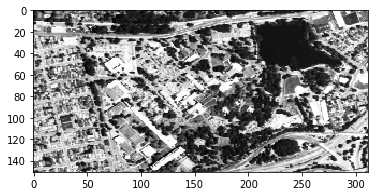

In [1]:
# Tell Jupyter to show images in this browser window Matlab style instead of popping out
%matplotlib inline

# debugging flags. Reloads include files every execution.
%load_ext autoreload 
%autoreload 2

import pprint
pp = pprint.PrettyPrinter(indent=4)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import the Google Earth Engine Library
import ee

# And all my helper functions:
from gee_library import *

# This command initializes the library and connects to Google's servers.
ee.Initialize()

# Now we'll load up some satelite imagery of Monterey.
# Don't worry too much about the details; just make sure an image appears below to confirm
# that your installation is working.
nps_bounds = bound_geometry(
                        (-121.880742, 36.600885),
                        (-121.866788, 36.594170))
tiles = img_at_region(ee.ImageCollection('USDA/NAIP/DOQQ'), 5, 'R', nps_bounds)
plt.imshow(tiles['R'], cmap='gray')
plt.show()


In [2]:

# First we create load a collection from the GEE database. 
world_collection = ee.ImageCollection('USDA/NAIP/DOQQ')

# An ee.ImageCollection is a collection of images. Each image contains certain spectrum bands. The
# world_collection we just created has thousands of images included in it; operating on such a large
# collection takes a long time. But we aren't interested in the whole world. We're just interested
# in a small area. Let's pare down the collection.

# We have to create an official ee.Geomtery object to communicate to Google Earth Engine the
# spatial bounds that we are interested in. I created a helper (factory?) function that creates 
# this object. 
nps_bounds = bound_geometry(
                        (-121.880742, 36.600885),
                        (-121.866788, 36.594170))
    
# We can use that object to apply a filter to the world_collection to only include images
# that intersect the spatial bounds we define.   
monterey_collection = world_collection.filterBounds(nps_bounds)

print collection_length(monterey_collection), "images available in monterey_collection."

# That's a much more reasonable amount of images. But why are there 13 images of this one region?
# The answer is that each image was taken at a diffent time. I've created a helper function to query
# which dates are abvailable in a collection.
dates_of_images = dates_available(monterey_collection)
print "Dates available:",dates_of_images

# I also created a function to query which bands are available in a collection.
available_bands_in_monterey = available_bands(monterey_collection)
for k, v in available_bands_in_monterey.items():
    print "Band", k, "is available in", v['number_available'], "images. (", v['percent_available'], "%)"
    
# This imagery is available in 4 bands: R (red), G (green), B(blue), and N (near-IR)

13 images available in monterey_collection.
Dates available: ['2009-06-22', '2010-05-29', '2012-05-20', '2014-06-14', '2016-07-12', '2009-06-22', '2010-05-29', '2012-05-20', '2014-06-13', '2016-06-19', '2005-06-13', '2005-06-13', '2004-06-28']
Band B is available in 13 images. ( 100 %)
Band R is available in 13 images. ( 100 %)
Band G is available in 13 images. ( 100 %)
Band N is available in 13 images. ( 100 %)


## Displaying Imagery

Now that we've explored which images and bands are available in this collection, let's look at some of them.

We'll try to load the most recent imagery first, then compare it with the older imagery.

At 5 meters/pixel, nps_bounds meaures {'width': 249.72770774332193, 'height': 149.03407121991768}
Imagery of NPS, taken at 2016-07-12
{'R': './tmp/45313721/map_section.R.tif'}


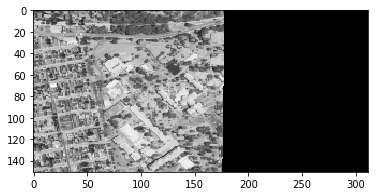

Requesting images from 2016-06-19 and 2016-07-12
{'R': './tmp/39676439/map_section.R.tif'}


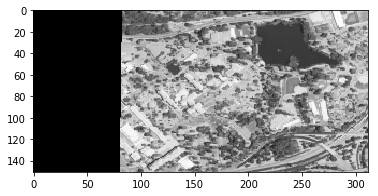

Fusing images from 2016-06-19 and 2016-07-12 by specifying the range 2016-06-19 - 2016-07-13
{'R': './tmp/39170514/map_section.R.tif'}


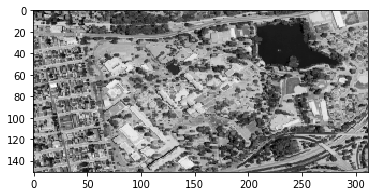

Imagery from 2005
{'R': './tmp/81307148/map_section.R.tif'}


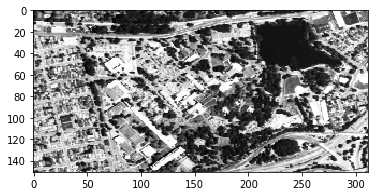

In [3]:
# When loading imagery, we have to decide which resolution we want, measured in meters per pixel.
# I created a helper function that, given a geometry bound box and resolution, will estimate the
# image size that will result. (Pulling too large of an image will often result in error/failure.)
# Note that this is very rough estimate and has some projection issues right now.
estimated_size = estimate_image_size_at_resolution(nps_bounds, 5)
print "At 5 meters/pixel, nps_bounds meaures", estimated_size

# Load the most recent imagery
print "Imagery of NPS, taken at 2016-07-12"
new_monterey_collection = monterey_collection.filter(ee.Filter.date('2016-07-12'))
tiles = img_at_region(new_monterey_collection, 5, 'R', nps_bounds)
plt.imshow(tiles['R'], cmap='gray'); plt.show()

# It looks like the imagery from that day only includes part of our FOV.
# Let's also include the second-most recent image, and let Google fuse them together.
print "Requesting images from 2016-06-19 and 2016-07-12"
new_monterey_collection = monterey_collection.filter(ee.Filter.date('2016-06-19', '2016-07-12'))
tiles_combined = img_at_region(new_monterey_collection, 5, 'R', nps_bounds)
plt.imshow(tiles_combined['R'], cmap='gray'); plt.show()


# Oops, the end date is exclusive (the range won't include the actual date.)
# Lets just add a day to the end date so it gets included.
print "Fusing images from 2016-06-19 and 2016-07-12 by specifying the range 2016-06-19 - 2016-07-13"
new_monterey_collection = monterey_collection.filter(ee.Filter.date('2016-06-19', '2016-07-13'))
tiles_combined = img_at_region(new_monterey_collection, 5, 'R', nps_bounds)
plt.imshow(tiles_combined['R'], cmap='gray'); plt.show()

# Let's compare this with the earliest snapshots.
print "Imagery from 2005"
old_monterey_collection = monterey_collection.filter(ee.Filter.date('2005-06-13'))
tiles_combined = img_at_region(old_monterey_collection, 5, 'R', nps_bounds)
plt.imshow(tiles_combined['R'], cmap='gray'); plt.show()

## Combining bands

We've been pulling only the R band so far, and displaying it as a grayscale image. We can combine multiple bands into a single image as well. Since the choice of bands and their order are very application-specific, I haven't provided any helper functions to do it for us, but don't worry, it's easy!

{'B': './tmp/72010346/map_section.B.tif', 'R': './tmp/72010346/map_section.R.tif', 'G': './tmp/72010346/map_section.G.tif'}


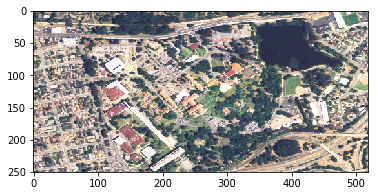

In [4]:
# We'll import numpy to help with the matrix operations.
import numpy as np

# Let's download the bands in the visible spectrum.
tiles = img_at_region(monterey_collection, 3, ['R','G', 'B'], nps_bounds)

# Numpy can stack 2 dimentional images in a 3rd dimention using the command dstack. Note that the output of the command
# is a numpy array, not a traditional python List. This is a detail that won't affect us here but might trip you
# up if your script calls List specific functions like len().
img = np.dstack((tiles['R'], tiles['G'], tiles['B']))

# We plot it the same way, but the cmap parameter is uneccessary since matplotlib will use true colors.
plt.imshow(img); plt.show()
    

## Pulling images with specific dimentions

A lot of analytics require that the data be supplied at constant dimentions. When working with satelite imagery this constraint applies twice: constant spatial extent and constant pixel dimentions.

I've created a function that is able to solve the first of these constraints although I'm still working on the second. I have one solution below.

{'R': './tmp/89505312/map_section.R.tif'}
The image has dimentions (302, 373) ; we expected (300, 300)
After interpolation, the image has dimentions (300, 300)


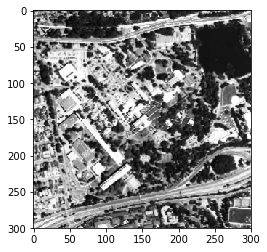

In [7]:
import scipy.misc


nps_center = [ -121.873925, 36.596853]


# I've created a function that calculates a square geometry with equal height and width in meters. Since the
# function uses a radius to calculate distance, it requires a half_distance parameter, which defines half the
# length of each side of the square. Below we request a geometry that desribes a square patch of land, centered
# at NPS, measureing 900 meters on easch side.
tile_bounds = square_centered_at(
    point = nps_center,
    half_distance = 450
)

# We can use that geometry to request imagery the same way as before. Since our patch is 900 meters on every side,
# requesting a resolution of 3 meters per pixel should result in an image that is 300x300 pixels.
tiles = img_at_region(monterey_collection, 3, ['R'], tile_bounds)

# We'll convert the image into a Numpy array and look at the dimentions.
img = np.array(tiles['R'])
print "The image has dimentions", img.shape,"; we expected (300, 300)"

# Hmm, I don't know why the width always overshoots. Probably something to do with the projection.
# We'll fix that (as well as the pixel or two difference in the other axis) by resizing using bilinear interpolation.
img = scipy.misc.imresize(img, (300, 300))
print "After interpolation, the image has dimentions", img.shape

plt.imshow(img, cmap='gray'); plt.show()
